In [23]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

from orbit.utils.stan import get_compiled_stan_model_simplified, compile_stan_model_simplified
from orbit.utils.dataset import load_iclaims
import arviz as az

In [24]:
ss_model_path = "./stan/ss_local_level_reg.stan"
compiled_path = compile_stan_model_simplified(ss_model_path)
ss_mod = get_compiled_stan_model_simplified(compiled_path)
del compiled_path

In [25]:
# fake data
# np.random.seed(2022)
# x = np.random.normal(0, 0.2, 100)
# y = np.cumsum(x) + np.random.normal(0, 1.0, 100)
# y = (y - np.mean(y))/np.std(y)

In [26]:
raw_data = load_iclaims()
y = raw_data['claims']
y = (y - np.mean(y))/np.std(y)

In [27]:
def make_fourier_series(n, period, order=3, shift=0):
    t = np.arange(1, n + 1) + shift
    out = list()
    for i in range(1, order + 1):
        x = 2.0 * i * np.pi * t / period
        out.append(np.cos(x))
        out.append(np.sin(x))
    out = np.column_stack(out)
    return out

In [28]:
intercept_reg = np.ones((len(y), 1))
fs_reg = make_fourier_series(len(y), 52, order=3)
xreg = np.concatenate([intercept_reg, fs_reg], -1)
m = xreg.shape[1]
a1 = np.array([y[1]] + [0.0] * (m-1))
p1 = np.zeros_like(a1)

In [29]:
data = {
    'N': len(y),
    'M': m,
    'Y' : y,
    'XREG' : xreg,
    'SD_Y' : 1.0,
    'A1' : a1,
    'P1' : p1,
    'STATE_SIGMA_MEAN': np.ones(m) * 0.1,
    'STATE_SIGMA_SD': np.ones(m),
    'OBS_SIGMA_MEAN': 0.8,
    'OBS_SIGMA_SD': 1.0,
}

In [32]:
ss_fit = ss_mod.sampling(
    data=data,
    warmup=3000,
    iter=4000,
    chains=4,
    # control={'max_treedepth' : 5, 'adapt_delta' : 0.5},
)


Gradient evaluation took 0.001131 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.31 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001193 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001395 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.95 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001129 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.29 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  800 / 40

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


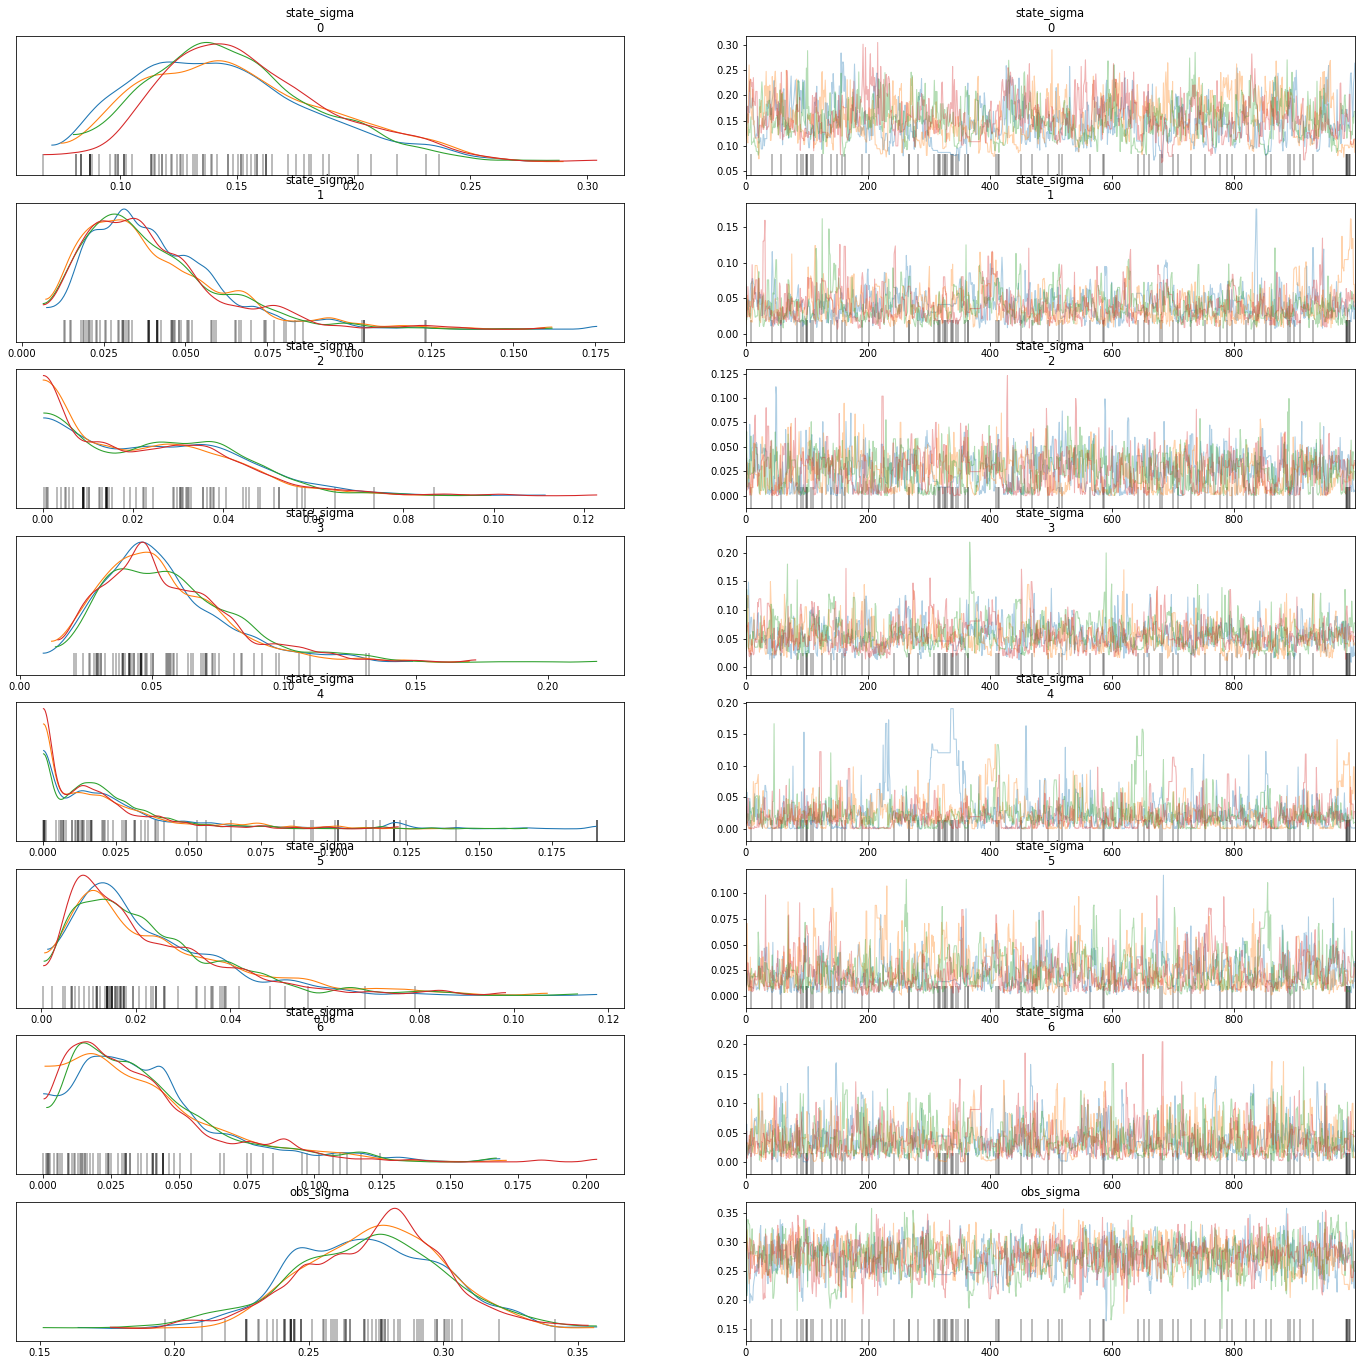

In [33]:
az_posteriors = az.from_pystan(ss_fit)
az.plot_trace(az_posteriors, var_names=['state_sigma', 'obs_sigma'], compact=False, figsize=(24, 24));

In [34]:
ss_posteriors = ss_fit.extract(pars=['state_sigma', 'states', 'obs_sigma','a'], permuted=True)
states = ss_posteriors['states']
states.shape

(4000, 444, 7)

In [35]:
yhat = np.sum(states[:, :-1, :] * np.expand_dims(xreg, 0), -1)
yhat_upper, yhat_med, yhat_lower = np.quantile(yhat, q=[0.9, 0.5, 0.1], axis=0)

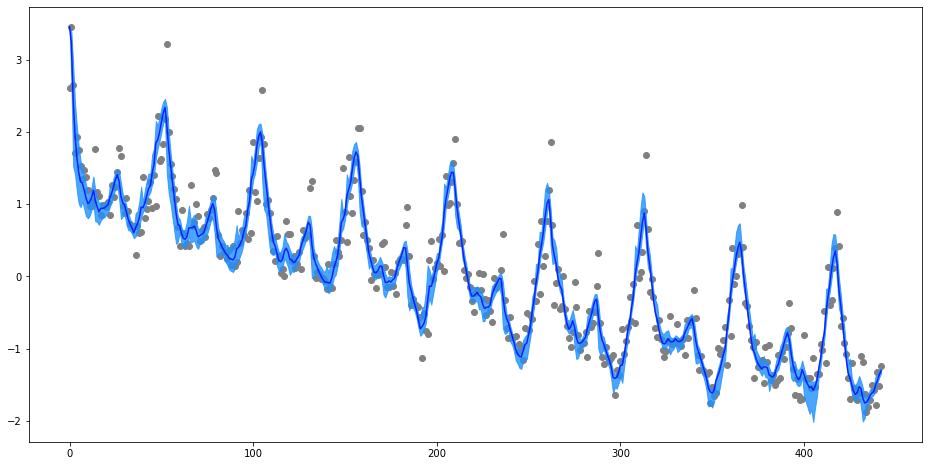

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(0, len(y))
ax.scatter(x, y, c='grey')
ax.plot(x, yhat_med, color='blue', alpha=0.8);
ax.fill_between(x=x, y1=yhat_lower, y2=yhat_upper, color='dodgerblue', alpha=0.8);